<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

<h2 style="text-align: center;"><b>Основы фреймворка TensorFlow</b></h2>

<img src="https://cdn-images-1.medium.com/max/1600/1*eFRgat2Iy6wZpi_DEItKgA.png" width=300 height=225>

<h4 style="text-align: center;"><b>Составитель: Илья Захаркин (ФИВТ МФТИ, NeurusLab). По всем вопросам в Telegram: <a>@ilyazakharkin</a></b></h4>

В этом ноутбуке мы более близко познакомимся с TF и попрактикуемся в классификации на FashionMNIST с помощью этого фреймворка. Пайплайн у него очень похож на PyTorch и Keras, однако есть много технических нюансов, которым и посвящён этот ноутбук.

*Примечание*: рекомендуется выполнять этот ноутбук в Google Colab во избежание проблем с установкой (если ставить `tensorflow`  без GPU, то проблем, на самом деле, быть не должно).

<h3 style="text-align: center;"><b>Основы: граф и сессия</b></h3>

Если tf не установлен:

In [0]:
# !pip install tensorflow

Импортируем:

In [0]:
import tensorflow as tf

In [2]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3659108345271152442, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 15993577647872154050
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8629575718796549207
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14800692839
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9791317141579468920
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

В TF есть две основные сущности -- это ***граф вычислений `tf.Graph()`*** и ***сессия `tf.Session()`***.

Сначала *строится* граф вычислений, а потом в сессии он *исполняется*.

Пример графа вычислений (очень условный):

<img src="https://camo.qiitausercontent.com/137bc298bf30fe06e61b59a638fea966d272f2b8/68747470733a2f2f71696974612d696d6167652d73746f72652e73332e616d617a6f6e6177732e636f6d2f302f313034362f38663430386438392d666563362d643761632d633961662d3865393061383039613233622e706e67" width=300 height=400>

А вот пример реального графа (скрин из TensorBoard):

<img src="https://blog.altoros.com/wp-content/uploads/2016/05/visualizing-graphs-with-tensorboard-wxb-group.png">

То есть граф -- это нечто построенное нами до сессии, а сессия -- это то, во время чего все операции в графе исполняются (при подаче в него входных данных).

Помимо этого введения, есть много замечательных курсов по этому фреймворку, например:

* Начать можно с официального intro: https://www.tensorflow.org/guide/low_level_intro 
* Продолжить этими замечательными практикумами: https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd
* Посмотреть что-то здесь, если не очень понятно: https://github.com/Hvass-Labs/TensorFlow-Tutorials
* Закончить продвинутым курсом: https://github.com/sjchoi86/advanced-tensorflow

И не забудьте заглянуть в официальные туториалы: https://www.tensorflow.org/tutorials/

<h3 style="text-align: center;"><b>Основные объекты</b></h3>

Используя https://www.tensorflow.org/guide/low_level_intro

#### Тензоры (Tensor)

Центральный объект -- это **тензоры `tf.Tensor`**. Это те же `np.array` из `numpy`, только обёрнуты в специальный класс `tf.Tensor`.

Давайте сразу посмотрим на простой пример объявления двух констнатныз тензоров и взятия от них матричного произведения:

In [0]:
c = tf.constant([[1.0, 2.0], [3.0, 4.0]])
d = tf.constant([[1.0, 1.0], [0.0, 1.0]])
e = tf.matmul(c, d)

Посомтрим на типы того, чтоы мы создали:

In [0]:
c

<tf.Tensor 'Const:0' shape=(2, 2) dtype=float32>

In [0]:
d

<tf.Tensor 'Const_1:0' shape=(2, 2) dtype=float32>

In [0]:
e

<tf.Tensor 'MatMul:0' shape=(2, 2) dtype=float32>

Обратите внимание: выводится тип объекта, его имя, shape и тип элементов, которые лежат внутри тензора.

Как видим, никакой матрицы-результата мы не получили. Это потому, что мы лишь объявлии граф вычислений, но сами вычисления ещё не зпустили. Для этого нужно объявить сессию и исполнить в ней этот граф:

In [0]:
sess = tf.Session()

result = sess.run(e)

In [0]:
result

array([[1., 3.],
       [3., 7.]], dtype=float32)

In [0]:
type(result)

numpy.ndarray

Видим, что при выполнении графа произведение посчиталось и результат положился в виде `np.array` в переменную `result`.

Заметьте: мы не объявляли в начале отедльный граф, поэтмоу текущий граф вычислений можно оплучить так: `tf.get_default_graph()`

In [0]:
tf.get_default_graph()

Давайте визуализируем этот граф с помощью TensorBoard **(сработает только на локальной машине, не на Colab)**:

In [0]:
writer = tf.summary.FileWriter('.')
writer.add_graph(tf.get_default_graph())
writer.flush()

In [0]:
# pip install tensorboard
# tensorboard --logdir .

Чтобы посмотреть на результат TensorBoard, перейдите в любом браузере по адресу `http://localhost:6006/#graphs` (работает только на локальной машине, не на Colab (однако есть способ, попробуйте разобраться самостоятельно: https://www.dlology.com/blog/quick-guide-to-run-tensorboard-in-google-colab/)

<img src="https://www.tensorflow.org/images/getting_started_add.png">

Ещё пример:

In [0]:
a = tf.constant(3.0, dtype=tf.float32)
b = tf.constant(4.0)
total = a + b
print(a)
print(b)
print(total)

Tensor("Const_2:0", shape=(), dtype=float32)
Tensor("Const_3:0", shape=(), dtype=float32)
Tensor("add:0", shape=(), dtype=float32)


In [0]:
sess = tf.Session()
print(sess.run(total))

7.0


Поучительный прмиер, говорящий о том, что при генерации случайных чисел и запуске вычисления графа, вычисления одного тензора происходят **один раз на запуск**, то есть:

In [0]:
vec = tf.random_uniform(shape=(3,))
out1 = vec + 1
out2 = vec + 2
print(sess.run(vec))
print(sess.run(vec))
print(sess.run((out1, out2)))

[0.58837104 0.6558658  0.05079556]
[0.7437582  0.1334356  0.73476017]
(array([1.827934 , 1.3887756, 1.0503138], dtype=float32), array([2.827934 , 2.3887756, 2.050314 ], dtype=float32))


Обратите внимание, что у out1 и out2 был один и тот же тензор vec на входе.

#### Плейсхолдеры (Placeholder)

Для того чтобы иметь возможность подавать на вход графу какие-то свои тензоры, используют **`tf.Placeholder()`**.

In [0]:
x = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)
z = x + y

In [0]:
x

<tf.Tensor 'Placeholder:0' shape=<unknown> dtype=float32>

In [0]:
y

<tf.Tensor 'Placeholder_1:0' shape=<unknown> dtype=float32>

In [0]:
z

<tf.Tensor 'add_3:0' shape=<unknown> dtype=float32>

Это всё те же тензоры в графе вычислений, но они не имеют значений -- их нужно **"скормить" ("feed")** самому:

In [0]:
print(sess.run(z, feed_dict={x: 3, y: 4.5}))

7.5


== *"вычисли значения тензора z, если на вход подаются x=3 и y=4.5"*

In [0]:
print(sess.run(z, feed_dict={x: [1, 3], y: [2, 4]}))

[3. 7.]


== *"вычисли значения тензора z, если на вход подаются x=[1, 3] и y=[2, 4]"* 

#### Переменные (Variable)

Тензоры существуют только во время выполнения сессии, чтобы получить результат вычислений. Для того, чтобы сохранять значения тензоров, в TF есть **`tf.Variable()`**.

`tf.Variable` хранит в себе `tf.Tensor`, однако можно читать и менять его значения в течение нескольких сессий, то есть `Variable` ближе к питоновскому понятию переменной, которая хранится в оперативной памяти компьютера.

Создать переменную можно так:

In [0]:
my_variable = tf.get_variable("my_variable", [1, 2, 3])
my_variable

In [0]:
my_variable.graph

Сейчас она тоже прикреплена к графу по-умолчанию:

In [0]:
tf.get_default_graph()

(такой вывод можно сделать, потому что адреса графа в памяти совпадают)

Создадим ещё одну и инициализируем константной:

In [0]:
other_variable = tf.get_variable("other_variable", dtype=tf.int32,
                                 initializer=tf.constant([23, 42]))

Запустим сессию, чтобы посомтреть на значения переменных (сейчас должна быть ошибка):

In [0]:
sess.run(my_variable)
sess.run(other_variable)

Ничего не вышло, потому что сначала переменные надо инициализировать:

In [0]:
sess.run(tf.global_variables_initializer())

Теперь должно получиться:

In [0]:
sess.run(my_variable)

In [0]:
sess.run(other_variable)

Всё верно: вторая переменная ининцилизировалась своим значеним, заданным в конструкторе, а первая -- случайным "мусором".

<h3 style="text-align: center;"><b>К практике</b></h3>

Напишем свой нейрон на tensorflow. 

Ниже пример регрессии по 4 точкам с помощью одного нейрона 

In [0]:
x = tf.constant([[1], [2], [3], [4]], dtype=tf.float32)
y_true = tf.constant([[0], [-1], [-2], [-3]], dtype=tf.float32)

Нарисуем:

In [0]:
import matplotlib.pyplot as plt

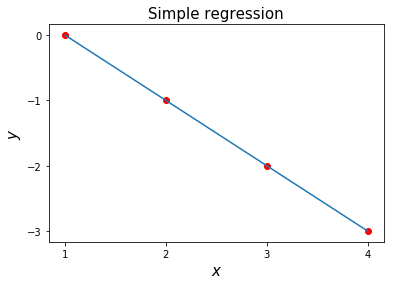

In [0]:
x_values, y_values = sess.run([x, y_true])

plt.scatter(x_values, y_values, c='r');
plt.plot(x_values, y_values);

plt.xticks(x_values)
plt.yticks(y_values)

plt.title('Simple regression', fontsize=15)
plt.xlabel('$x$', fontsize=15)
plt.ylabel('$y$', fontsize=15);

Объявим линейную регрессию:

In [0]:
linear_model = tf.layers.Dense(units=1)

y_pred = linear_model(x)

In [0]:
linear_model

In [0]:
y_pred

<tf.Tensor 'dense/BiasAdd:0' shape=(4, 1) dtype=float32>

Функция потерь -- среднеквадратичная, оптимизатор -- градиентный спуск:

In [0]:
loss = tf.losses.mean_squared_error(labels=y_true, predictions=y_pred)

optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(loss)

Иницилизируем переменные, обЪявим сессию и запусим в ней обучение:

In [0]:
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)
for i in range(100):
    _, loss_value = sess.run((train, loss))
    print('loss: ', loss_value)

print(sess.run(y_pred))

loss:  5.9492755
loss:  4.2083697
loss:  2.9999123
loss:  2.1609118
loss:  1.5782728
loss:  1.1735202
loss:  0.8922025
loss:  0.6965361
loss:  0.5603043
loss:  0.46531558
loss:  0.39894727
loss:  0.35244098
loss:  0.31971908
loss:  0.29656467
loss:  0.28005153
loss:  0.2681494
loss:  0.25944936
loss:  0.2529738
loss:  0.24804443
loss:  0.24419047
loss:  0.24108538
loss:  0.23850246
loss:  0.23628442
loss:  0.2343221
loss:  0.23253979
loss:  0.23088482
loss:  0.22932084
loss:  0.2278223
loss:  0.22637182
loss:  0.22495706
loss:  0.22356945
loss:  0.22220327
loss:  0.22085424
loss:  0.21951956
loss:  0.21819721
loss:  0.21688583
loss:  0.21558434
loss:  0.21429212
loss:  0.21300858
loss:  0.21173348
loss:  0.21046643
loss:  0.20920733
loss:  0.20795599
loss:  0.20671229
loss:  0.20547614
loss:  0.20424746
loss:  0.20302613
loss:  0.20181224
loss:  0.20060557
loss:  0.19940615
loss:  0.19821388
loss:  0.19702879
loss:  0.19585073
loss:  0.1946798
loss:  0.1935158
loss:  0.1923588
loss:  0

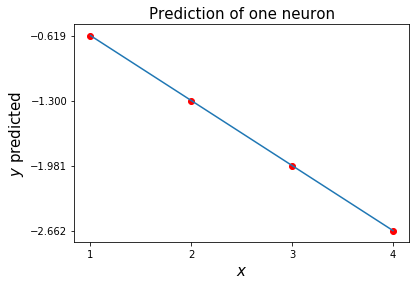

In [0]:
x_values, y_values = sess.run([x, y_pred])

plt.scatter(x_values, y_values, c='r');
plt.plot(x_values, y_values);

plt.xticks(x_values)
plt.yticks(y_values)

plt.title('Prediction of one neuron', fontsize=15)
plt.xlabel('$x$', fontsize=15)
plt.ylabel('$y$ predicted', fontsize=15);

<h3 style="text-align: center;"><b>FashionMNIST (5 баллов)</b></h3>

Для обучения нейросетей на TensorFlow обычно используют либо модуль `.keras` (который, по сути, является Keras'ом, только обращение к нему происходит через TF), либо модуль `tf.Slim`. В этом задании Вам нужно самостоятельно написть обучение нейросети на датасете FashionMNIST и добиться качества (поклассового `accuracy`) **больше, чем 0.9**.

Бейзланом к этому заданию является официальный туториал TensorFlow: https://www.tensorflow.org/tutorials/keras/basic_classification

*Hint*: можно использовать свёрточные слои и слои не из туториала

In [3]:
from tensorflow import keras

# А также добавим вспомогательные библиотеки для вычислений и вывода данных на экран
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.13.1


In [4]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [6]:
train_images.shape

(60000, 28, 28)

In [7]:
len(train_labels)

60000

In [8]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [9]:
test_images.shape

(10000, 28, 28)

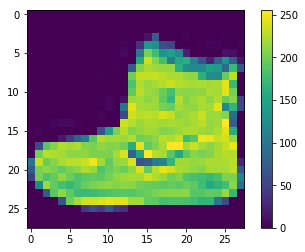

In [66]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [10]:
train_images[0].reshape(-1, 28, 28, 1).shape


(1, 28, 28, 1)

In [69]:
train_images.shape

(60000, 28, 28)

In [0]:

train_images = train_images.reshape(-1,28,28,1)
train_images = train_images / 255.0

test_images = test_images.reshape(-1,28,28,1)
test_images = test_images / 255.0

In [12]:
train_images.shape

(60000, 28, 28, 1)

In [0]:
#one-hot
#from tensorflow.contrib.keras.python.keras.utils import np_utils
y_train = tf.keras.utils.to_categorical(train_labels)
y_test = tf.keras.utils.to_categorical(test_labels)

In [0]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

In [0]:
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D

In [17]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (5, 5), padding="same", input_shape=[28, 28, 1]),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Conv2D(64, (5, 5), padding="same"),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [18]:
model.compile(keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images, y_train, validation_split=0.10, batch_size=64, epochs=25, verbose=2)

Train on 54000 samples, validate on 6000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/25
 - 9s - loss: 0.6077 - acc: 0.7876 - val_loss: 0.4114 - val_acc: 0.8522
Epoch 2/25
 - 5s - loss: 0.3952 - acc: 0.8599 - val_loss: 0.3503 - val_acc: 0.8735
Epoch 3/25
 - 5s - loss: 0.3454 - acc: 0.8771 - val_loss: 0.3209 - val_acc: 0.8852
Epoch 4/25
 - 5s - loss: 0.3147 - acc: 0.8867 - val_loss: 0.3073 - val_acc: 0.8878
Epoch 5/25
 - 5s - loss: 0.2912 - acc: 0.8966 - val_loss: 0.2850 - val_acc: 0.8932
Epoch 6/25
 - 5s - loss: 0.2715 - acc: 0.9009 - val_loss: 0.2766 - val_acc: 0.8975
Epoch 7/25
 - 5s - loss: 0.2546 - acc: 0.9089 - val_loss: 0.2662 - val_acc: 0.9005
Epoch 8/25
 - 5s - loss: 0.2416 - acc: 0.9124 - val_loss: 0.2570 - val_acc: 0.9038
Epoch 9/25
 - 5s - loss: 0.2279 - acc: 0.9167 - val_loss: 0.2442 - val_acc: 0.9108
Epoch 10/25
 - 5s - loss: 0.2156 - acc: 0.9208 - val_loss: 0.2433 - val_acc: 0.9107
Epoch 11/25
 - 5s - loss: 0.2068 - acc: 0.9240 - val_loss: 0.2401 - val_

In [19]:
test_loss, test_acc = model.evaluate(test_images, y_test)

print('Точность после проверки:', test_acc)

10000/10000 [==============================] - 1s 63us/sample - loss: 0.2460 - acc: 0.9210
Точность после проверки: 0.921


<h3 style="text-align: center;"><b>На выбор: Style Transfer или CIFAR10 (каждое по 5 баллов)</b></h3>

В этой части Вам нужно самостоятельно реализовать перенос стиля на TensorFlow или написать классификацию датасета CIFAR10. Можно сделать и то, и то, тогда вы получите 10 баллов, а не 5, и за всё задание будет 15, а не 10.

#### Neural Style Transfer:
Бейзлайн по переносу стиля: https://github.com/tensorflow/models/blob/master/research/nst_blogpost/4_Neural_Style_Transfer_with_Eager_Execution.ipynb
Это уже почти решение, надо только написать это сюда и объяснить каждый шаг, и показать пример работы на своих картинках.

Качаем картинки

In [0]:
import os
img_dir = '/tmp/nst'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/6/68/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg

импортируем библиотеки

In [0]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools

In [0]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

Это опция для более простой и наглядной работы с графами, позволяет их редактировать во время работы

In [4]:
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


In [0]:
# Set up some global values here
content_path = '/tmp/nst/Green_Sea_Turtle_grazing_seagrass.jpg'
style_path = '/tmp/nst/The_Great_Wave_off_Kanagawa.jpg'

Функции для показа картинок

In [0]:
def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  img = kp_image.img_to_array(img)
  
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img
def imshow(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  # Normalize for display 
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

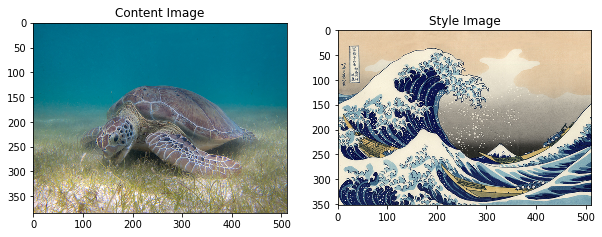

In [7]:
plt.figure(figsize=(10,10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

Функция для обработки картинки, чтобы она подошла по входным параметрам для vgg19

In [0]:
def load_and_process_img(path_to_img):
  img = load_img(path_to_img)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

Так как нам нужно будет на выходе получить картинку со значением пикселей от 0 до 255, то нужно сделать обратную обработку

In [0]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessiing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

Внутренние слои обученное нейронной сети выступают как извлекатели признаков, и чем дальше слой от начала, тем более сложные признаки он извлекает. Поэтому мы берем один из верхних слоев как слой с содержимым картинки, а пять слоев перед ним - как слои, содержащие признаки стиля.

In [0]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

Загружаем предобученную модель, замораживаем, обьявляем слои стиля и содержимого, которые дадут на выходе.

In [0]:
def get_model():
  """ Creates our model with access to intermediate layers. 
  
  This function will load the VGG19 model and access the intermediate layers. 
  These layers will then be used to create a new model that will take input image
  and return the outputs from these intermediate layers from the VGG model. 
  
  Returns:
    returns a keras model that takes image inputs and outputs the style and 
      content intermediate layers. 
  """
  # Load our model. We load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  # Get output layers corresponding to style and content layers 
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  # Build model 
  return models.Model(vgg.input, model_outputs)

Функция для подсчета потерь содержимого - считает евклидово расстояние между входной картинкой и полученной после сетки.

In [0]:
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

Теперь мы считаем потери стиля. Здесь функция будет сложнее, мы вычисляем матрицы Грама на фичах выходной картинки и фичах слоя *l* входной картинки. После этого мы складываем потери на каждом стильном слое и в итоге получаем потерю стиля.

In [0]:
def gram_matrix(input_tensor):
  # We make the image channels first 
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
  """Expects two images of dimension h, w, c"""
  # height, width, num filters of each layer
  # We scale the loss at a given layer by the size of the feature map and the number of filters
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

Вспомогательная функция для вычисления представлений признаков содержимого и стиля

In [0]:
def get_feature_representations(model, content_path, style_path):
  """Helper function to compute our content and style feature representations.

  This function will simply load and preprocess both the content and style 
  images from their path. Then it will feed them through the network to obtain
  the outputs of the intermediate layers. 
  
  Arguments:
    model: The model that we are using.
    content_path: The path to the content image.
    style_path: The path to the style image
    
  Returns:
    returns the style features and the content features. 
  """
  # Load our images in 
  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)
  
  # batch compute content and style features
  style_outputs = model(style_image)
  content_outputs = model(content_image)
  
  
  # Get the style and content feature representations from our model  
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

Считаем общие потери

In [0]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  """This function will compute the loss total loss.
  
  Arguments:
    model: The model that will give us access to the intermediate layers
    loss_weights: The weights of each contribution of each loss function. 
      (style weight, content weight, and total variation weight)
    init_image: Our initial base image. This image is what we are updating with 
      our optimization process. We apply the gradients wrt the loss we are 
      calculating to this image.
    gram_style_features: Precomputed gram matrices corresponding to the 
      defined style layers of interest.
    content_features: Precomputed outputs from defined content layers of 
      interest.
      
  Returns:
    returns the total loss, style loss, content loss, and total variational loss
  """
  style_weight, content_weight = loss_weights
  
  # Feed our init image through our model. This will give us the content and 
  # style representations at our desired layers. Since we're using eager
  # our model is callable just like any other function!
  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0

  # Accumulate style losses from all layers
  # Here, we equally weight each contribution of each loss layer
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  # Accumulate content losses from all layers 
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

  # Get total loss
  loss = style_score + content_score 
  return loss, style_score, content_score

Вычисляем градент

In [0]:
def compute_grads(cfg):
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**cfg)
  # Compute gradients wrt input image
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

Собираем все в одну функцию для запуска переноса стиля

In [0]:
import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2): 
  # We don't need to (or want to) train any layers of our model, so we set their
  # trainable to false. 
  model = get_model() 
  for layer in model.layers:
    layer.trainable = False
  
  # Get the style and content feature representations (from our specified intermediate layers) 
  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  # Set initial image
  init_image = load_and_process_img(content_path)
  init_image = tfe.Variable(init_image, dtype=tf.float32)
  # Create our optimizer
  opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

  # For displaying intermediate images 
  iter_count = 1
  
  # Store our best result
  best_loss, best_img = float('inf'), None
  
  # Create a nice config 
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
    
  # For displaying
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    
    if loss < best_loss:
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()
      
      # Use the .numpy() method to get the concrete numpy array
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
      
  return best_img, best_loss 

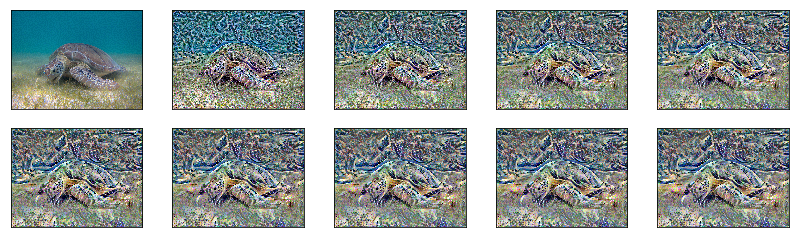

In [18]:
best, best_loss = run_style_transfer(content_path, 
                                     style_path, num_iterations=1000)

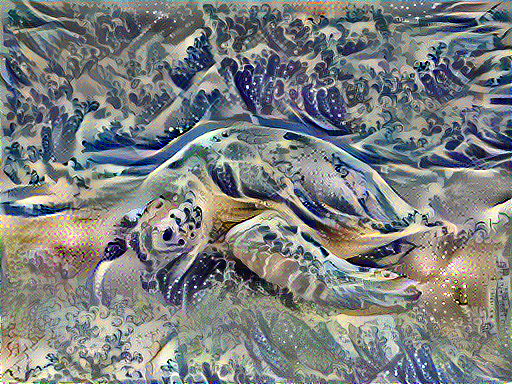

In [19]:
Image.fromarray(best)

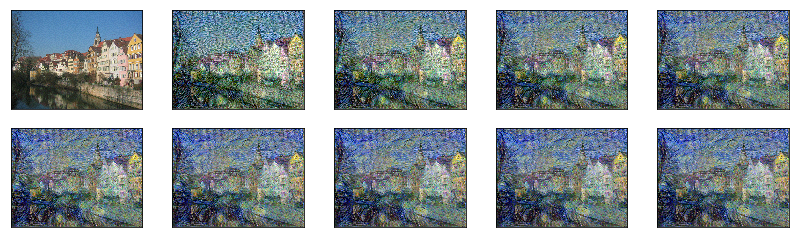

In [20]:
best_starry_night, best_loss = run_style_transfer('/tmp/nst/Tuebingen_Neckarfront.jpg',
                                                  '/tmp/nst/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg')

In [0]:
!wget --quiet -P /tmp/nst/ https://static.ngs.ru/news/99/preview/6a810a0abe2908fbda1a66a2227cec87215cee6ed_900.jpg
!wget --quiet -P /tmp/nst/ http://www.wassilykandinsky.ru/images/works/1.jpg

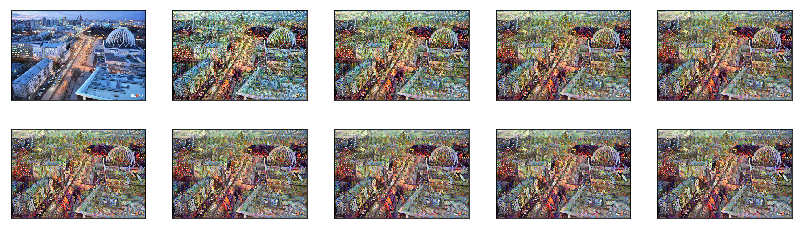

In [22]:
best_starry_night, best_loss = run_style_transfer('/tmp/nst/6a810a0abe2908fbda1a66a2227cec87215cee6ed_900.jpg',
                                                  '/tmp/nst/1.jpg')

In [0]:
def show_results(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path) 
  style = load_img(style_path)

  plt.subplot(1, 2, 1)
  imshow(content, 'Content Image')

  plt.subplot(1, 2, 2)
  imshow(style, 'Style Image')

  if show_large_final: 
    plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

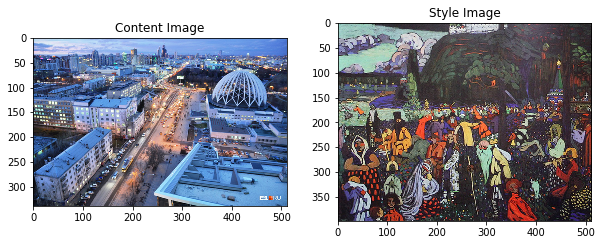

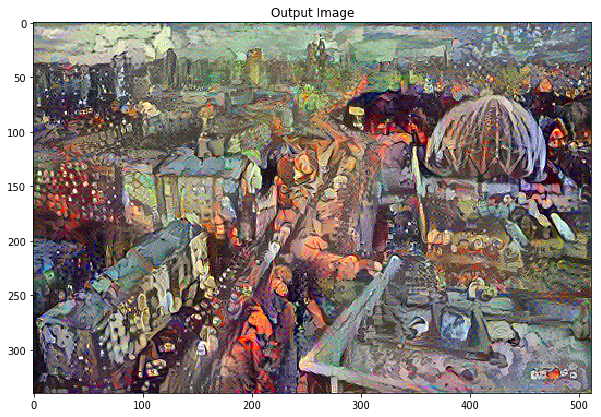

In [25]:
show_results(best_starry_night, 
             '/tmp/nst/6a810a0abe2908fbda1a66a2227cec87215cee6ed_900.jpg',
             '/tmp/nst/1.jpg')

#### CIFAR10:
Бейзлайн по классификации CIFAR10: https://www.tensorflow.org/tutorials/images/deep_cnn  
Там есть ссылки на файлы с кодом, который тоже можно прямо сюда вставлять, главное, чтобы качество в итоге получилось хорошим (формально порог не задан, будет смотреться у всех индивиуально).

In [0]:
<Покажите класс>

In [0]:
...